# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

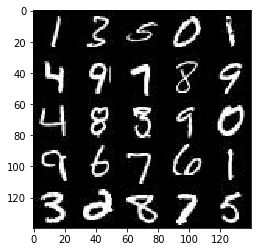

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

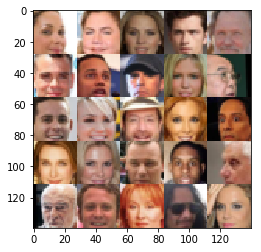

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape = (None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, shape = (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [6]:
def lrelu(bn, alpha=0.2):
    return tf.maximum(alpha * bn, bn)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = lrelu(bn1)
        # 16x16x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = lrelu(bn2)
        # 8x8x256
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = lrelu(bn3)
        # 4x4x512

        # Flatten it
        flat = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)

        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = lrelu(x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = lrelu(x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = lrelu(x3)
        # 28x28x128 now
        
        # Output layer
        out = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same', activation=tf.tanh)
        # 28x28x3 now
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1, beta2=0.9).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1, beta2=0.9).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height,image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    is_train = tf.placeholder(tf.bool)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                 # Run optimizers
                _ = sess.run(d_opt,
                             feed_dict={input_z: batch_z,
                                        input_real: batch_images,
                                        lr: learning_rate})
                _ = sess.run(g_opt, 
                             feed_dict={input_z: batch_z, 
                                        input_real: batch_images,
                                        lr: learning_rate})
                                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    #Print the current image
                    show_generator_output(sess, 50, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.9998... Generator Loss: 4.7412
Epoch 1/2... Discriminator Loss: 6.2856... Generator Loss: 0.0923
Epoch 1/2... Discriminator Loss: 4.4603... Generator Loss: 0.0646
Epoch 1/2... Discriminator Loss: 3.9661... Generator Loss: 0.0548
Epoch 1/2... Discriminator Loss: 3.0092... Generator Loss: 0.0970
Epoch 1/2... Discriminator Loss: 2.6476... Generator Loss: 0.0990
Epoch 1/2... Discriminator Loss: 2.6715... Generator Loss: 0.1057
Epoch 1/2... Discriminator Loss: 2.1981... Generator Loss: 0.1807
Epoch 1/2... Discriminator Loss: 1.9021... Generator Loss: 0.2351
Epoch 1/2... Discriminator Loss: 2.3753... Generator Loss: 0.1357


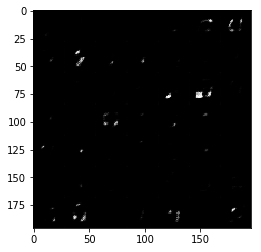

Epoch 1/2... Discriminator Loss: 1.8703... Generator Loss: 0.2401
Epoch 1/2... Discriminator Loss: 2.0877... Generator Loss: 0.1700
Epoch 1/2... Discriminator Loss: 1.9286... Generator Loss: 0.2041
Epoch 1/2... Discriminator Loss: 1.8063... Generator Loss: 0.3159
Epoch 1/2... Discriminator Loss: 2.0939... Generator Loss: 0.2002
Epoch 1/2... Discriminator Loss: 1.9014... Generator Loss: 0.3029
Epoch 1/2... Discriminator Loss: 1.6597... Generator Loss: 0.3417
Epoch 1/2... Discriminator Loss: 1.7735... Generator Loss: 0.2540
Epoch 1/2... Discriminator Loss: 1.8440... Generator Loss: 0.3224
Epoch 1/2... Discriminator Loss: 2.1455... Generator Loss: 1.8257


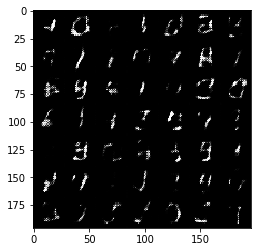

Epoch 1/2... Discriminator Loss: 1.7894... Generator Loss: 1.4913
Epoch 1/2... Discriminator Loss: 1.8578... Generator Loss: 1.2740
Epoch 1/2... Discriminator Loss: 1.7582... Generator Loss: 1.5108
Epoch 1/2... Discriminator Loss: 1.7243... Generator Loss: 1.5549
Epoch 1/2... Discriminator Loss: 1.8314... Generator Loss: 1.3580
Epoch 1/2... Discriminator Loss: 1.9837... Generator Loss: 1.5093
Epoch 1/2... Discriminator Loss: 1.5979... Generator Loss: 1.4111
Epoch 1/2... Discriminator Loss: 1.6862... Generator Loss: 1.3686
Epoch 1/2... Discriminator Loss: 1.4004... Generator Loss: 1.1192
Epoch 1/2... Discriminator Loss: 1.6253... Generator Loss: 0.8727


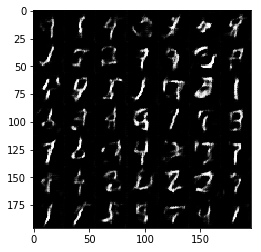

Epoch 1/2... Discriminator Loss: 1.8938... Generator Loss: 0.2398
Epoch 1/2... Discriminator Loss: 2.1906... Generator Loss: 0.1617
Epoch 1/2... Discriminator Loss: 2.0799... Generator Loss: 0.2572
Epoch 1/2... Discriminator Loss: 2.0081... Generator Loss: 0.1946
Epoch 1/2... Discriminator Loss: 1.9075... Generator Loss: 0.2182
Epoch 1/2... Discriminator Loss: 2.1592... Generator Loss: 0.1668
Epoch 1/2... Discriminator Loss: 1.6663... Generator Loss: 0.3310
Epoch 1/2... Discriminator Loss: 1.7437... Generator Loss: 0.8121
Epoch 1/2... Discriminator Loss: 1.9639... Generator Loss: 0.2393
Epoch 1/2... Discriminator Loss: 1.8449... Generator Loss: 0.2526


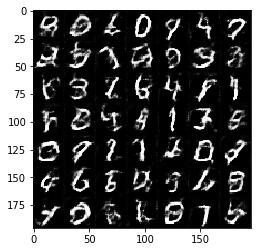

Epoch 1/2... Discriminator Loss: 1.6230... Generator Loss: 0.3869
Epoch 1/2... Discriminator Loss: 1.5980... Generator Loss: 0.7321
Epoch 1/2... Discriminator Loss: 1.6009... Generator Loss: 1.0383
Epoch 1/2... Discriminator Loss: 1.8142... Generator Loss: 1.4143
Epoch 1/2... Discriminator Loss: 1.4887... Generator Loss: 1.2350
Epoch 1/2... Discriminator Loss: 1.6039... Generator Loss: 1.0910
Epoch 1/2... Discriminator Loss: 1.9630... Generator Loss: 0.2069
Epoch 1/2... Discriminator Loss: 1.6143... Generator Loss: 0.3692
Epoch 1/2... Discriminator Loss: 1.6732... Generator Loss: 0.3425
Epoch 1/2... Discriminator Loss: 1.6367... Generator Loss: 0.3173


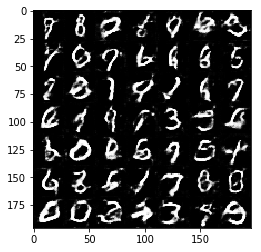

Epoch 1/2... Discriminator Loss: 1.5675... Generator Loss: 0.4779
Epoch 1/2... Discriminator Loss: 1.4521... Generator Loss: 1.0770
Epoch 1/2... Discriminator Loss: 1.4218... Generator Loss: 1.2427
Epoch 1/2... Discriminator Loss: 1.3630... Generator Loss: 0.8141
Epoch 1/2... Discriminator Loss: 1.6179... Generator Loss: 1.3086
Epoch 1/2... Discriminator Loss: 1.5620... Generator Loss: 1.3231
Epoch 1/2... Discriminator Loss: 1.6110... Generator Loss: 1.1940
Epoch 1/2... Discriminator Loss: 1.4925... Generator Loss: 1.2316
Epoch 1/2... Discriminator Loss: 1.3610... Generator Loss: 1.1613
Epoch 1/2... Discriminator Loss: 1.4091... Generator Loss: 0.8063


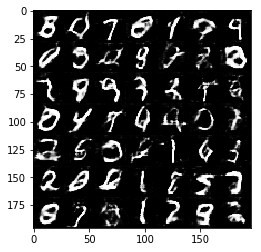

Epoch 1/2... Discriminator Loss: 1.4600... Generator Loss: 1.0966
Epoch 1/2... Discriminator Loss: 1.4439... Generator Loss: 1.0850
Epoch 1/2... Discriminator Loss: 2.1810... Generator Loss: 0.1798
Epoch 1/2... Discriminator Loss: 1.3327... Generator Loss: 0.5471
Epoch 1/2... Discriminator Loss: 1.6074... Generator Loss: 0.3477
Epoch 1/2... Discriminator Loss: 1.5903... Generator Loss: 0.4713
Epoch 1/2... Discriminator Loss: 1.9365... Generator Loss: 0.2297
Epoch 1/2... Discriminator Loss: 1.4354... Generator Loss: 0.6447
Epoch 1/2... Discriminator Loss: 1.5691... Generator Loss: 1.1532
Epoch 1/2... Discriminator Loss: 1.3132... Generator Loss: 0.9695


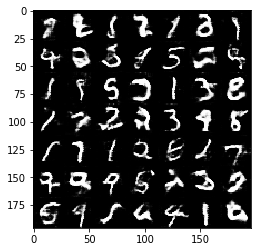

Epoch 1/2... Discriminator Loss: 1.1714... Generator Loss: 0.9827
Epoch 1/2... Discriminator Loss: 1.8361... Generator Loss: 1.6129
Epoch 1/2... Discriminator Loss: 1.2746... Generator Loss: 1.0860
Epoch 1/2... Discriminator Loss: 1.8196... Generator Loss: 0.2532
Epoch 1/2... Discriminator Loss: 1.5021... Generator Loss: 0.4012
Epoch 1/2... Discriminator Loss: 1.9389... Generator Loss: 0.1961
Epoch 1/2... Discriminator Loss: 1.4157... Generator Loss: 0.4740
Epoch 1/2... Discriminator Loss: 1.8111... Generator Loss: 0.2383
Epoch 1/2... Discriminator Loss: 1.3194... Generator Loss: 0.5356
Epoch 1/2... Discriminator Loss: 1.5430... Generator Loss: 0.3609


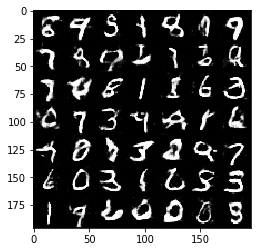

Epoch 1/2... Discriminator Loss: 1.2483... Generator Loss: 0.7836
Epoch 1/2... Discriminator Loss: 1.3730... Generator Loss: 1.1487
Epoch 1/2... Discriminator Loss: 1.2662... Generator Loss: 1.3523
Epoch 1/2... Discriminator Loss: 1.6424... Generator Loss: 1.2844
Epoch 1/2... Discriminator Loss: 1.1131... Generator Loss: 1.2418
Epoch 1/2... Discriminator Loss: 1.4993... Generator Loss: 1.1725
Epoch 1/2... Discriminator Loss: 1.6289... Generator Loss: 1.3335
Epoch 1/2... Discriminator Loss: 1.2227... Generator Loss: 1.2092
Epoch 1/2... Discriminator Loss: 1.2773... Generator Loss: 0.6513
Epoch 1/2... Discriminator Loss: 1.9817... Generator Loss: 0.2166


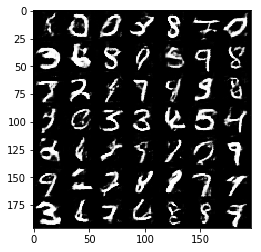

Epoch 1/2... Discriminator Loss: 1.4516... Generator Loss: 0.5102
Epoch 1/2... Discriminator Loss: 1.5307... Generator Loss: 0.3819
Epoch 1/2... Discriminator Loss: 1.4774... Generator Loss: 0.3693
Epoch 2/2... Discriminator Loss: 1.3487... Generator Loss: 0.5149
Epoch 2/2... Discriminator Loss: 1.4744... Generator Loss: 0.3662
Epoch 2/2... Discriminator Loss: 1.2477... Generator Loss: 0.6337
Epoch 2/2... Discriminator Loss: 1.7516... Generator Loss: 0.2900
Epoch 2/2... Discriminator Loss: 1.2270... Generator Loss: 0.5447
Epoch 2/2... Discriminator Loss: 1.3940... Generator Loss: 0.5097
Epoch 2/2... Discriminator Loss: 1.4407... Generator Loss: 0.4717


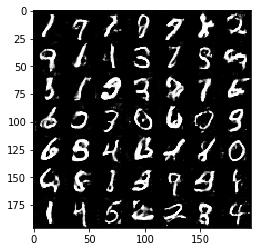

Epoch 2/2... Discriminator Loss: 1.5788... Generator Loss: 0.3335
Epoch 2/2... Discriminator Loss: 1.1541... Generator Loss: 1.4943
Epoch 2/2... Discriminator Loss: 1.2673... Generator Loss: 1.5076
Epoch 2/2... Discriminator Loss: 1.7722... Generator Loss: 0.3408
Epoch 2/2... Discriminator Loss: 1.2257... Generator Loss: 0.5784
Epoch 2/2... Discriminator Loss: 1.7715... Generator Loss: 1.6378
Epoch 2/2... Discriminator Loss: 1.2562... Generator Loss: 1.1313
Epoch 2/2... Discriminator Loss: 1.4197... Generator Loss: 0.4152
Epoch 2/2... Discriminator Loss: 1.2306... Generator Loss: 0.6219
Epoch 2/2... Discriminator Loss: 1.1228... Generator Loss: 0.7746


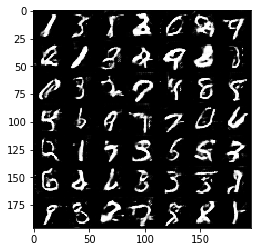

Epoch 2/2... Discriminator Loss: 1.1496... Generator Loss: 1.2751
Epoch 2/2... Discriminator Loss: 1.0770... Generator Loss: 1.1773
Epoch 2/2... Discriminator Loss: 1.2233... Generator Loss: 0.5117
Epoch 2/2... Discriminator Loss: 1.1440... Generator Loss: 0.9413
Epoch 2/2... Discriminator Loss: 1.3488... Generator Loss: 0.4501
Epoch 2/2... Discriminator Loss: 1.0508... Generator Loss: 0.9292
Epoch 2/2... Discriminator Loss: 1.7838... Generator Loss: 1.9483
Epoch 2/2... Discriminator Loss: 1.1860... Generator Loss: 1.3374
Epoch 2/2... Discriminator Loss: 1.8199... Generator Loss: 1.8356
Epoch 2/2... Discriminator Loss: 1.0748... Generator Loss: 1.2238


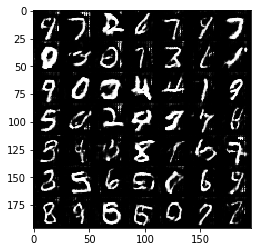

Epoch 2/2... Discriminator Loss: 0.9451... Generator Loss: 1.1550
Epoch 2/2... Discriminator Loss: 1.2300... Generator Loss: 1.7360
Epoch 2/2... Discriminator Loss: 0.8971... Generator Loss: 1.1305
Epoch 2/2... Discriminator Loss: 0.9874... Generator Loss: 1.5809
Epoch 2/2... Discriminator Loss: 2.3885... Generator Loss: 0.1631
Epoch 2/2... Discriminator Loss: 1.2613... Generator Loss: 0.9517
Epoch 2/2... Discriminator Loss: 1.2285... Generator Loss: 0.5157
Epoch 2/2... Discriminator Loss: 1.0529... Generator Loss: 0.8273
Epoch 2/2... Discriminator Loss: 0.9732... Generator Loss: 0.7638
Epoch 2/2... Discriminator Loss: 1.7167... Generator Loss: 0.2504


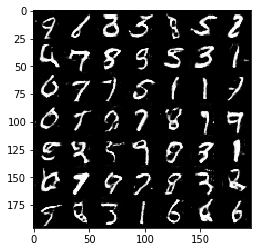

Epoch 2/2... Discriminator Loss: 0.9932... Generator Loss: 0.8217
Epoch 2/2... Discriminator Loss: 1.6758... Generator Loss: 0.3406
Epoch 2/2... Discriminator Loss: 1.4523... Generator Loss: 0.4730
Epoch 2/2... Discriminator Loss: 1.4496... Generator Loss: 0.4077
Epoch 2/2... Discriminator Loss: 1.1620... Generator Loss: 0.9680
Epoch 2/2... Discriminator Loss: 1.2259... Generator Loss: 1.2311
Epoch 2/2... Discriminator Loss: 0.7167... Generator Loss: 1.0993
Epoch 2/2... Discriminator Loss: 1.4195... Generator Loss: 0.4425
Epoch 2/2... Discriminator Loss: 1.5182... Generator Loss: 0.3810
Epoch 2/2... Discriminator Loss: 0.8233... Generator Loss: 0.9491


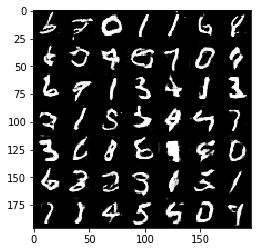

Epoch 2/2... Discriminator Loss: 1.5135... Generator Loss: 0.4534
Epoch 2/2... Discriminator Loss: 0.7035... Generator Loss: 1.2183
Epoch 2/2... Discriminator Loss: 1.0809... Generator Loss: 0.6487
Epoch 2/2... Discriminator Loss: 1.0946... Generator Loss: 0.5705
Epoch 2/2... Discriminator Loss: 1.0558... Generator Loss: 0.7005
Epoch 2/2... Discriminator Loss: 1.8828... Generator Loss: 0.2285
Epoch 2/2... Discriminator Loss: 1.0584... Generator Loss: 0.8008
Epoch 2/2... Discriminator Loss: 0.6086... Generator Loss: 1.1872
Epoch 2/2... Discriminator Loss: 1.0372... Generator Loss: 1.7061
Epoch 2/2... Discriminator Loss: 0.7161... Generator Loss: 1.4891


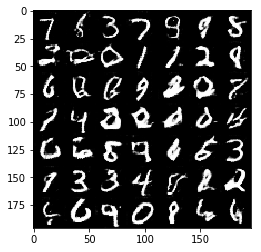

Epoch 2/2... Discriminator Loss: 0.8582... Generator Loss: 1.4975
Epoch 2/2... Discriminator Loss: 1.0091... Generator Loss: 0.7336
Epoch 2/2... Discriminator Loss: 2.3681... Generator Loss: 0.1529
Epoch 2/2... Discriminator Loss: 0.8837... Generator Loss: 0.9044
Epoch 2/2... Discriminator Loss: 1.1618... Generator Loss: 0.5469
Epoch 2/2... Discriminator Loss: 1.1102... Generator Loss: 0.7633
Epoch 2/2... Discriminator Loss: 1.7767... Generator Loss: 0.2949
Epoch 2/2... Discriminator Loss: 0.6032... Generator Loss: 1.4372
Epoch 2/2... Discriminator Loss: 0.6134... Generator Loss: 1.5707
Epoch 2/2... Discriminator Loss: 1.0033... Generator Loss: 1.8009


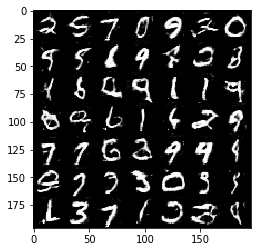

Epoch 2/2... Discriminator Loss: 0.7346... Generator Loss: 1.2989
Epoch 2/2... Discriminator Loss: 0.9858... Generator Loss: 1.8796
Epoch 2/2... Discriminator Loss: 0.6382... Generator Loss: 1.6080
Epoch 2/2... Discriminator Loss: 2.0013... Generator Loss: 3.2300
Epoch 2/2... Discriminator Loss: 0.8156... Generator Loss: 1.6797
Epoch 2/2... Discriminator Loss: 0.7584... Generator Loss: 0.9824
Epoch 2/2... Discriminator Loss: 1.9151... Generator Loss: 0.2706
Epoch 2/2... Discriminator Loss: 0.8521... Generator Loss: 2.5772
Epoch 2/2... Discriminator Loss: 1.0633... Generator Loss: 0.6129
Epoch 2/2... Discriminator Loss: 0.5451... Generator Loss: 1.2734


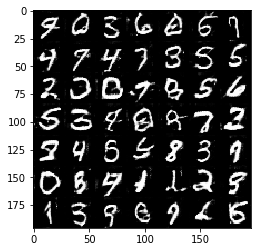

Epoch 2/2... Discriminator Loss: 1.5005... Generator Loss: 0.4020
Epoch 2/2... Discriminator Loss: 1.0537... Generator Loss: 0.6803
Epoch 2/2... Discriminator Loss: 1.1281... Generator Loss: 3.1799
Epoch 2/2... Discriminator Loss: 0.5600... Generator Loss: 1.1901
Epoch 2/2... Discriminator Loss: 0.9098... Generator Loss: 2.1434
Epoch 2/2... Discriminator Loss: 1.0865... Generator Loss: 2.6616
Epoch 2/2... Discriminator Loss: 0.4248... Generator Loss: 1.7609
Epoch 2/2... Discriminator Loss: 0.4991... Generator Loss: 1.5440
Epoch 2/2... Discriminator Loss: 0.5734... Generator Loss: 1.9688
Epoch 2/2... Discriminator Loss: 2.4498... Generator Loss: 0.1760


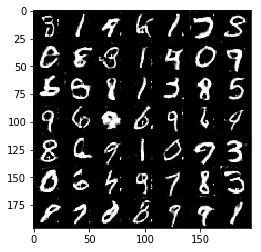

Epoch 2/2... Discriminator Loss: 1.0400... Generator Loss: 0.7406
Epoch 2/2... Discriminator Loss: 1.4755... Generator Loss: 0.6220
Epoch 2/2... Discriminator Loss: 0.3863... Generator Loss: 1.5517
Epoch 2/2... Discriminator Loss: 1.8854... Generator Loss: 0.2751
Epoch 2/2... Discriminator Loss: 0.3728... Generator Loss: 1.9796
Epoch 2/2... Discriminator Loss: 3.2736... Generator Loss: 0.0963
Epoch 2/2... Discriminator Loss: 0.4013... Generator Loss: 2.1096


In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2234... Generator Loss: 9.4652
Epoch 1/1... Discriminator Loss: 4.2724... Generator Loss: 0.4512
Epoch 1/1... Discriminator Loss: 3.1684... Generator Loss: 0.1226
Epoch 1/1... Discriminator Loss: 3.0608... Generator Loss: 0.0854
Epoch 1/1... Discriminator Loss: 1.5122... Generator Loss: 1.0885
Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.9881
Epoch 1/1... Discriminator Loss: 0.8334... Generator Loss: 0.9916
Epoch 1/1... Discriminator Loss: 0.5056... Generator Loss: 1.6585
Epoch 1/1... Discriminator Loss: 2.4595... Generator Loss: 0.1389
Epoch 1/1... Discriminator Loss: 0.5806... Generator Loss: 1.0245


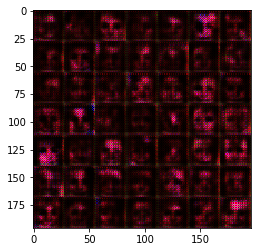

Epoch 1/1... Discriminator Loss: 0.3769... Generator Loss: 1.6832
Epoch 1/1... Discriminator Loss: 0.9875... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 1.7692
Epoch 1/1... Discriminator Loss: 0.4718... Generator Loss: 5.8488
Epoch 1/1... Discriminator Loss: 5.6462... Generator Loss: 0.1039
Epoch 1/1... Discriminator Loss: 3.6835... Generator Loss: 5.2021
Epoch 1/1... Discriminator Loss: 4.7007... Generator Loss: 5.1007
Epoch 1/1... Discriminator Loss: 1.9342... Generator Loss: 0.5096
Epoch 1/1... Discriminator Loss: 1.3489... Generator Loss: 1.2569
Epoch 1/1... Discriminator Loss: 1.5349... Generator Loss: 1.1308


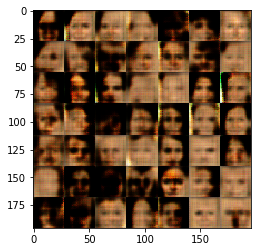

Epoch 1/1... Discriminator Loss: 1.7566... Generator Loss: 0.5130
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 1.7759
Epoch 1/1... Discriminator Loss: 1.7824... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.6423... Generator Loss: 1.0787
Epoch 1/1... Discriminator Loss: 1.8622... Generator Loss: 1.4501
Epoch 1/1... Discriminator Loss: 1.5302... Generator Loss: 0.9011
Epoch 1/1... Discriminator Loss: 1.7042... Generator Loss: 0.4346
Epoch 1/1... Discriminator Loss: 1.8257... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 2.0383... Generator Loss: 1.4291
Epoch 1/1... Discriminator Loss: 1.7500... Generator Loss: 0.6724


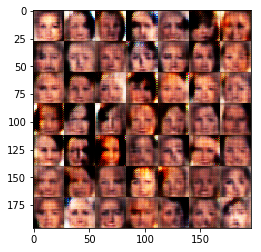

Epoch 1/1... Discriminator Loss: 2.3471... Generator Loss: 0.1361
Epoch 1/1... Discriminator Loss: 1.6409... Generator Loss: 1.1315
Epoch 1/1... Discriminator Loss: 1.6147... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.7234... Generator Loss: 1.0096
Epoch 1/1... Discriminator Loss: 1.6467... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.7511... Generator Loss: 0.5882
Epoch 1/1... Discriminator Loss: 1.5487... Generator Loss: 0.4041
Epoch 1/1... Discriminator Loss: 1.6552... Generator Loss: 0.4168
Epoch 1/1... Discriminator Loss: 1.7896... Generator Loss: 0.4405
Epoch 1/1... Discriminator Loss: 1.6338... Generator Loss: 0.8956


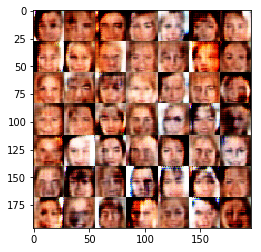

Epoch 1/1... Discriminator Loss: 1.6903... Generator Loss: 1.1510
Epoch 1/1... Discriminator Loss: 1.6025... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 1.5229... Generator Loss: 0.3867
Epoch 1/1... Discriminator Loss: 1.5988... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.6497... Generator Loss: 1.0978
Epoch 1/1... Discriminator Loss: 1.6231... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.8131... Generator Loss: 0.2969
Epoch 1/1... Discriminator Loss: 1.5638... Generator Loss: 0.5122
Epoch 1/1... Discriminator Loss: 1.5730... Generator Loss: 0.5367


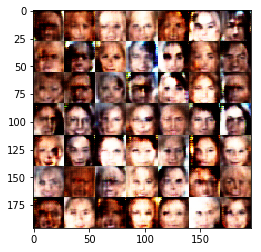

Epoch 1/1... Discriminator Loss: 1.5158... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 1.6466... Generator Loss: 0.4779
Epoch 1/1... Discriminator Loss: 1.5636... Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 1.5386... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.6400... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 1.6026... Generator Loss: 1.1450
Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.9771
Epoch 1/1... Discriminator Loss: 1.5828... Generator Loss: 0.4470
Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.7160


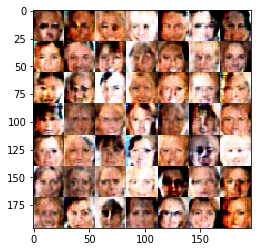

Epoch 1/1... Discriminator Loss: 1.4929... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.4775
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.5094
Epoch 1/1... Discriminator Loss: 1.6783... Generator Loss: 1.0568
Epoch 1/1... Discriminator Loss: 1.7916... Generator Loss: 0.4019
Epoch 1/1... Discriminator Loss: 1.7800... Generator Loss: 0.3449
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.5449


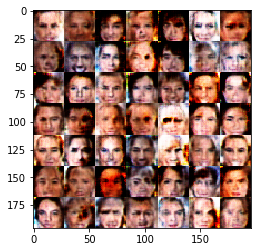

Epoch 1/1... Discriminator Loss: 1.6992... Generator Loss: 0.5337
Epoch 1/1... Discriminator Loss: 1.4908... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.5078... Generator Loss: 0.8648
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.8617
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.7799... Generator Loss: 0.4187


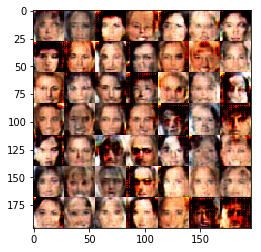

Epoch 1/1... Discriminator Loss: 1.4695... Generator Loss: 0.8495
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.9651
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.5220
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.4983... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 1.5661... Generator Loss: 0.5590
Epoch 1/1... Discriminator Loss: 1.5134... Generator Loss: 0.7617


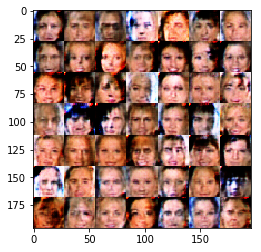

Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.5512
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.5268... Generator Loss: 0.5935
Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.9007
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.5176
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.5145
Epoch 1/1... Discriminator Loss: 1.7109... Generator Loss: 0.3165
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.6499


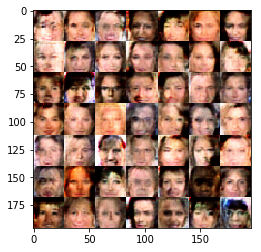

Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.4805
Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 0.6292
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.5831
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 0.5655
Epoch 1/1... Discriminator Loss: 1.6065... Generator Loss: 0.6126
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.5836


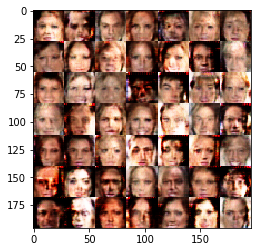

Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.8408
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.6026
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.5403
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.5773
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.6272
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.4620
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.8175


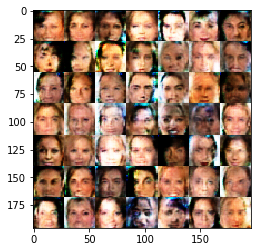

Epoch 1/1... Discriminator Loss: 1.4927... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.6069
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.5066
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.5427
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.5964
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.4971
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.5517
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.5723


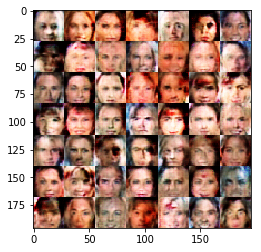

Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.8624
Epoch 1/1... Discriminator Loss: 1.4855... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.5750
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.5919


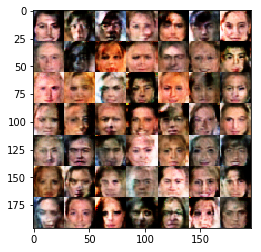

Epoch 1/1... Discriminator Loss: 1.4915... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.5896
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.8330


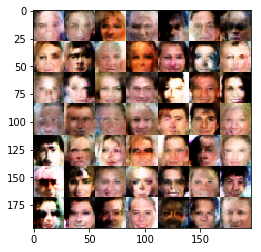

Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.5597
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.9409
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.5816
Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.5176
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.4470... Generator Loss: 0.5534
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.8797


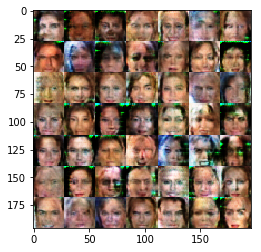

Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.5270
Epoch 1/1... Discriminator Loss: 1.5254... Generator Loss: 0.4685
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.5866
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.7619


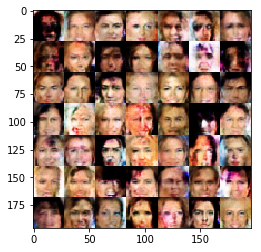

Epoch 1/1... Discriminator Loss: 1.4718... Generator Loss: 0.4766
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.8369
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.8515
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.5533
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.5245... Generator Loss: 0.4587


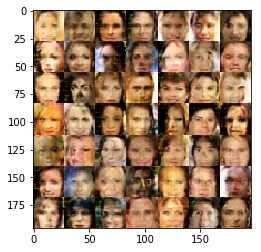

Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.5359
Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.9379
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.5127... Generator Loss: 0.4529
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.6677
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.5450
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.7410


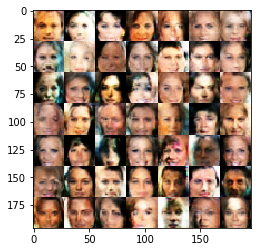

Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.5439
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.8301
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.4865
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.4545
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.7571


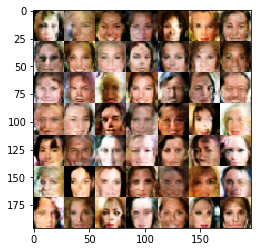

Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.5470... Generator Loss: 0.4569
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 1.5236... Generator Loss: 0.5005


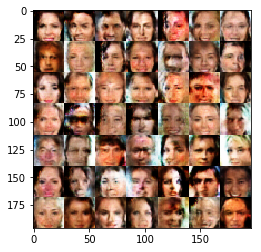

Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.6047
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.5123... Generator Loss: 0.4087
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.5618
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.8292
Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.5093


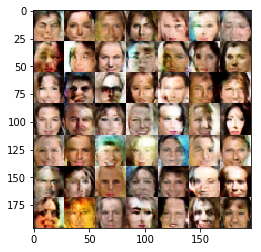

Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.6240
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.5278... Generator Loss: 0.4117
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.6162
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.5579
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.5674
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.6570


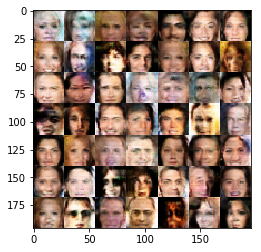

Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.5348
Epoch 1/1... Discriminator Loss: 1.5005... Generator Loss: 0.4792
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.5664
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.5209
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.5567
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.4803
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.5955


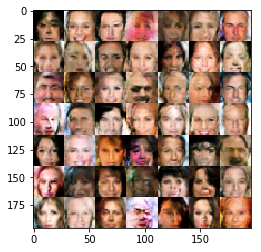

Epoch 1/1... Discriminator Loss: 1.4014... Generator Loss: 0.8559
Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.5042
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.4411... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.5080
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 0.9356
Epoch 1/1... Discriminator Loss: 1.5454... Generator Loss: 0.3858


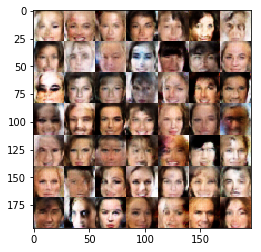

Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.4721
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.9389
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.6109
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.8728
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.5251
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.5317
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.5437
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.6493


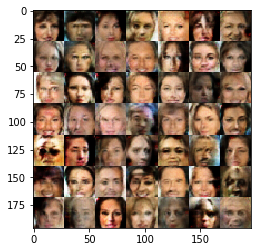

Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.8631
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.8827
Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 0.5021
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.7272


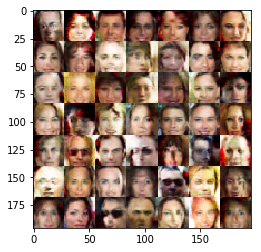

Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.9008
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.5468
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.5370
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.5571
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.6853


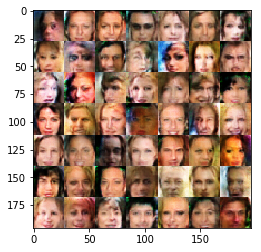

Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.9026
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.4734
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.8268


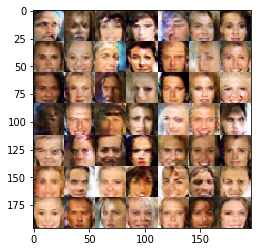

Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.5716
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.5449
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.5632
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.8462
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.6864


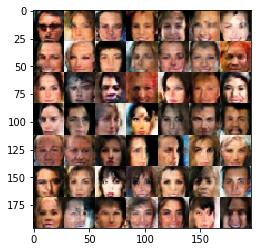

Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.9153
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.4955
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.4936
Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.5551
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.6157
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.6351


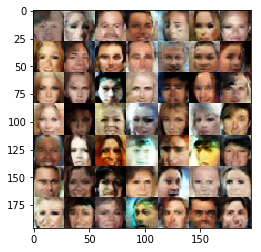

Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.4300... Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 0.8299


In [14]:
batch_size = 64
z_dim = 128
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.